<a href="https://colab.research.google.com/github/OllyMuh/ML_algorythms/blob/main/Decision%20Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ДЗ 4. Деревья решений**

## Практическое задание

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

1. В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

2. Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [ ]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

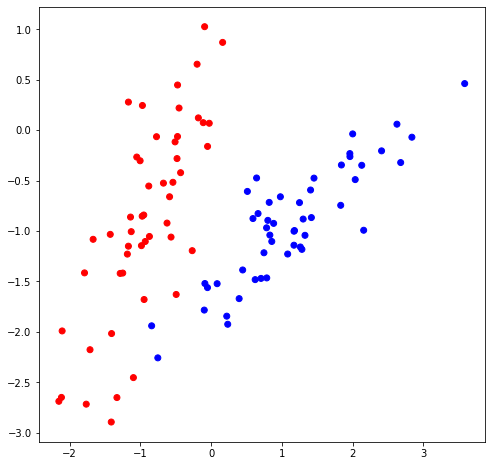

In [ ]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [ ]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [ ]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        # self.prediction = self.predict()
        self.mean_data = self.mean_data()
    
    def mean_data(self):
        # взятие среднего значения по выборке
        classes = {} #формируем словарь "класс: среднее значение данных"
        for label in self.labels:
              if label not in classes:
                classes[label] = [self.data]
              else:
                np.append(classes[label], self.data)
              classes[label] = np.mean(classes[label])

        # нужно найти класс, среднее значение данных которого максимально и вернуть его
        prediction = max(classes, key=classes.get)
        return prediction



    # def predict(self):
    #     # подсчет количества объектов разных классов
    #     classes = {}  # сформируем словарь "класс: количество объектов"
    #     for label in self.labels:
    #         if label not in classes:
    #             classes[label] = 0
    #         classes[label] += 1
    #     #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
    #     prediction = max(classes, key=classes.get)
    #     return prediction   

In [ ]:
# реализуем критерий дисперсии значений
def mse(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

In [ ]:
# Расчет качества результата

def information_gain(left_labels, right_labels, root_mse):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [ ]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [ ]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    root_mse = mse(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_gain = information_gain(true_labels, false_labels, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_quality:
                best_quality, best_t, best_index = current_gain, t, index

    return best_quality, best_t, best_index

In [ ]:
# Построение дерева с помощью рекурсивной функции
# Реализация критериев останова

def build_tree(data, labels, max_depth=3):
    depth_count = 0

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    # или работает критерий максимальной глубины дерева = max_depth
    elif depth_count == max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    depth_count += 1

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [ ]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        # answer = node.prediction
        answer = node.mean_data
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [ ]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [ ]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [ ]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [ ]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        # print(spacing + "Прогноз:", node.prediction)
        print(spacing + "Прогноз:", node.mean_data)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог 0.16261402870113306
--> True:
  Индекс 1
  Порог -1.5208896621663803
  --> True:
    Индекс 0
    Порог -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [ ]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [ ]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [ ]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [ ]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [ ]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

Здравствуйте. По форме замечаний нет, но по содержанию - есть нюансы.
Дерево регрессии нужно тестировать на регрессионных данных, а не классификационных. И метрику качества делать соответствующую.